## Problem Description

Production prediction is one of the core problems in our business. The provided dataset is a set of nearby wells located in the United States and their 12 months cumulative production. As a data scientist you want to build a model from scratch to predict production and show your manager that your model can perform well on unseen data.

Submitting material: code (Python/notebook) and supporting materials if needed (analysis, documentation, paper, slide)

## Feature Descriptions

- **treatment company**: The treatment company who provides treatment service.
- **azimuth**: Well drilling direction.
- **md (ft)**: Measure depth.
- **tvd (ft)**: True vertical depth.
- **date on production**: First production date.
- **operator**: The well operator who performs drilling service.
- **footage lateral length**: Horizontal well section.
- **well spacing**: Distance to the closest nearby well.
- **porpoise deviation**: How much max (in ft.) a well deviated from its horizontal.
- **porpoise count**: How many times the deviations (porpoises) occurred.
- **shale footage**: How much shale (in ft) encountered in a horizontal well.
- **acoustic impedance**: The impedance of a reservoir rock (ft/s * g/cc).
- **log permeability**: The property of rocks that is an indication of the ability for fluids (gas or liquid) to flow through rocks
- **porosity**: The percentage of void space in a rock. It is defined as the ratio of the volume of the voids or pore space divided by the total volume. It is written as either a decimal fraction between 0 and 1 or as a percentage.
- **poisson ratio**: Measures the ratio of lateral strain to axial strain at linearly elastic region.
- **water saturation**: The ratio of water volume to pore volume.
- **toc**: Total Organic Carbon, indicates the organic richness (hydrocarbon generative potential) of a reservoir rock.
- **vcl**: The amount of clay minerals in a reservoir rock.
- **p-velocity**: The velocity of P-waves (compressional waves) through a reservoir rock (ft/s).
- **s-velocity**: The velocity of S-waves (shear waves) through a reservoir rock (ft/s).
- **youngs modulus**: The ratio of the applied stress to the fractional extension (or shortening) of the reservoir rock parallel to the tension (or compression) (giga pascals).
- **isip**: When the pumps are quickly stopped, and the fluids stop moving, these friction pressures disappear and the resulting pressure is called the instantaneous shut-in pressure, ISIP.
- **breakdown pressure**: The pressure at which a hydraulic fracture is created/initiated/induced.
- **pump rate**: The volume of liquid that travels through the pump in a given time. A hydraulic fracture is formed by pumping fluid into a wellbore at a rate sufficient to increase pressure at the target depth, to exceed that of the fracture gradient (pressure gradient) of the rock.
- **total number of stages**: Total stages used to fracture the horizontal section of the well.
- **proppant volume**: The amount of proppant in pounds used in the completion of a well (lbs).
- **proppant fluid ratio**: The ratio of proppant volume/fluid volume (lbs/gallon).
- **production**: The 12 months cumulative gas production (mmcf).

# 0. Imports

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

## 0.1. Helper Functions

In [3]:
def settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    #display( HTML( '') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

settings()

# 1. Data Description

In [4]:
df1 = pd.read_csv('../data/interview_dataset.csv')

In [5]:
df1.head()

,treatment company,azimuth,md (ft),tvd (ft),date on production,operator,footage lateral length,well spacing,porpoise deviation,porpoise count,shale footage,acoustic impedance,log permeability,porosity,poisson ratio,water saturation,toc,vcl,p-velocity,s-velocity,youngs modulus,isip,breakdown pressure,pump rate,total number of stages,proppant volume,proppant fluid ratio,production
0,treatment company 1,-32.28,19148,6443.00,3/1/2018,operator 1,11966.00,4368.46,6.33,12,1093,30123.20,0.68,0.02,0.34,0.85,5.00,0.42,13592.23,6950.44,30.82,4149.00,NaN,83,56,21568792.00,1.23,5614.95
1,treatment company 2,-19.80,15150,7602.00,7/1/2014,operator 2,6890.00,4714.99,1.28,4,0,30951.61,1.85,0.17,0.19,0.69,4.22,0.74,11735.04,7162.45,29.72,5776.00,NaN,102,33,9841307.00,1.47,2188.84
2,treatment company 3,-26.88,14950,5907.00,8/1/2018,operator 1,8793.00,798.92,2.03,6,3254,28900.25,0.29,0.02,0.33,NaN,4.69,0.61,13227.81,6976.93,30.99,4628.00,NaN,88,62,17116240.00,1.67,1450.03
3,treatment company 4,-49.10,11098,6538.00,1/1/2012,operator 1,4234.00,NaN,6.00,23,7470,32826.08,0.73,0.03,0.20,NaN,4.40,0.56,12646.34,6799.37,26.20,4582.00,NaN,100,11,3749559.00,0.77,1060.76
4,treatment company 5,5.56,10549,7024.00,1/1/2012,operator 3,2972.00,2967.56,11.87,9,3637,26740.05,0.47,0.02,0.33,0.80,4.66,0.58,13192.18,7046.91,31.18,4909.00,NaN,94,9,6690705.00,1.32,607.53


## 1.1. Rename Columns

In [6]:
df1.columns

Index(['treatment company', 'azimuth', 'md (ft)', 'tvd (ft)',
       'date on production', 'operator', 'footage lateral length',
       'well spacing', 'porpoise deviation', 'porpoise count', 'shale footage',
       'acoustic impedance', 'log permeability', 'porosity', 'poisson ratio',
       'water saturation', 'toc', 'vcl', 'p-velocity', 's-velocity',
       'youngs modulus', 'isip', 'breakdown pressure', 'pump rate',
       'total number of stages', 'proppant volume', 'proppant fluid ratio',
       'production'],
      dtype='object')

In [7]:
# remove spaces in the column names

old_column_names = ['treatment company', 'azimuth', 'md (ft)', 'tvd (ft)', 'date on production', 'operator', 'footage lateral length', 'well spacing', 
                    'porpoise deviation', 'porpoise count', 'shale footage', 'acoustic impedance', 'log permeability', 'porosity', 'poisson ratio', 
                    'water saturation', 'toc', 'vcl', 'p-velocity', 's-velocity', 'youngs modulus', 'isip', 'breakdown pressure', 'pump rate', 
                    'total number of stages', 'proppant volume', 'proppant fluid ratio', 'production']

new_column_names = [old_name.replace(' ', '_') for old_name in old_column_names]

df1.columns = new_column_names

In [8]:
df1.columns

Index(['treatment_company', 'azimuth', 'md_(ft)', 'tvd_(ft)',
       'date_on_production', 'operator', 'footage_lateral_length',
       'well_spacing', 'porpoise_deviation', 'porpoise_count', 'shale_footage',
       'acoustic_impedance', 'log_permeability', 'porosity', 'poisson_ratio',
       'water_saturation', 'toc', 'vcl', 'p-velocity', 's-velocity',
       'youngs_modulus', 'isip', 'breakdown_pressure', 'pump_rate',
       'total_number_of_stages', 'proppant_volume', 'proppant_fluid_ratio',
       'production'],
      dtype='object')

## 1.2. Data Dimensions

In [9]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1000
Number of Cols: 28


## 1.3. Data Types

In [10]:
df1.dtypes

treatment_company          object
azimuth                   float64
md_(ft)                     int64
tvd_(ft)                  float64
date_on_production         object
operator                   object
footage_lateral_length    float64
well_spacing              float64
porpoise_deviation        float64
porpoise_count              int64
shale_footage               int64
acoustic_impedance        float64
log_permeability          float64
porosity                  float64
poisson_ratio             float64
water_saturation          float64
toc                       float64
vcl                       float64
p-velocity                float64
s-velocity                float64
youngs_modulus            float64
isip                      float64
breakdown_pressure        float64
pump_rate                   int64
total_number_of_stages      int64
proppant_volume           float64
proppant_fluid_ratio      float64
production                float64
dtype: object

In [11]:
# change 'date_on_production' data type to datetime

df1['date_on_production'] = pd.to_datetime(df1['date_on_production'])
df1.dtypes

treatment_company                 object
azimuth                          float64
md_(ft)                            int64
tvd_(ft)                         float64
date_on_production        datetime64[ns]
operator                          object
footage_lateral_length           float64
well_spacing                     float64
porpoise_deviation               float64
porpoise_count                     int64
shale_footage                      int64
acoustic_impedance               float64
log_permeability                 float64
porosity                         float64
poisson_ratio                    float64
water_saturation                 float64
toc                              float64
vcl                              float64
p-velocity                       float64
s-velocity                       float64
youngs_modulus                   float64
isip                             float64
breakdown_pressure               float64
pump_rate                          int64
total_number_of_

## 1.4. Check NA

In [12]:
df1.isna().sum()

treatment_company           0
azimuth                    55
md_(ft)                     0
tvd_(ft)                   20
date_on_production          0
operator                    0
footage_lateral_length      0
well_spacing              156
porpoise_deviation          0
porpoise_count              0
shale_footage               0
acoustic_impedance          0
log_permeability            0
porosity                  119
poisson_ratio               0
water_saturation          577
toc                        21
vcl                         0
p-velocity                  0
s-velocity                  0
youngs_modulus             19
isip                       77
breakdown_pressure        744
pump_rate                   0
total_number_of_stages      0
proppant_volume           132
proppant_fluid_ratio        0
production                  0
dtype: int64

In [13]:
# replace na values with mean

df1['azimuth'] = df1['azimuth'].replace(np.NaN, df1['azimuth'].mean())
df1['tvd_(ft)'] = df1['tvd_(ft)'].replace(np.NaN, df1['tvd_(ft)'].mean())
df1['well_spacing'] = df1['well_spacing'].replace(np.NaN, df1['well_spacing'].mean())
df1['porosity'] = df1['porosity'].replace(np.NaN, df1['porosity'].mean())
df1['water_saturation'] = df1['water_saturation'].replace(np.NaN, df1['water_saturation'].mean())
df1['toc'] = df1['toc'].replace(np.NaN, df1['toc'].mean())
df1['youngs_modulus'] = df1['youngs_modulus'].replace(np.NaN, df1['youngs_modulus'].mean())
df1['isip'] = df1['isip'].replace(np.NaN, df1['isip'].mean())
df1['breakdown_pressure'] = df1['breakdown_pressure'].replace(np.NaN, df1['breakdown_pressure'].mean())
df1['proppant_volume'] = df1['proppant_volume'].replace(np.NaN, df1['proppant_volume'].mean())

In [14]:
df1.isna().sum()

treatment_company         0
azimuth                   0
md_(ft)                   0
tvd_(ft)                  0
date_on_production        0
operator                  0
footage_lateral_length    0
well_spacing              0
porpoise_deviation        0
porpoise_count            0
shale_footage             0
acoustic_impedance        0
log_permeability          0
porosity                  0
poisson_ratio             0
water_saturation          0
toc                       0
vcl                       0
p-velocity                0
s-velocity                0
youngs_modulus            0
isip                      0
breakdown_pressure        0
pump_rate                 0
total_number_of_stages    0
proppant_volume           0
proppant_fluid_ratio      0
production                0
dtype: int64

## 1.5. Descriptive Statistics

In [15]:
numerical_attributes = df1.select_dtypes(include=['int64', 'float64'])
categorical_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.5.1. Numerical Attributes

In [16]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(numerical_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(numerical_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(numerical_attributes.apply(np.std)).T
d2 = pd.DataFrame(numerical_attributes.apply(min)).T
d3 = pd.DataFrame(numerical_attributes.apply(max)).T
d4 = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,azimuth,-87.25,22.94,110.19,-33.91,-33.91,17.47,0.01,0.40
1,md_(ft),8642.00,27797.00,19155.00,13988.39,13659.50,2583.02,0.93,1.70
2,tvd_(ft),4859.00,9639.00,4780.00,7103.62,7026.50,887.48,0.24,-0.72
3,footage_lateral_length,1329.00,19849.00,18520.00,6387.05,5927.00,2519.07,1.13,2.06
4,well_spacing,335.46,5225.09,4889.63,2223.23,2223.23,1152.34,0.61,-0.35
5,porpoise_deviation,0.03,1106.13,1106.10,50.46,10.88,118.38,4.13,20.33
6,porpoise_count,0.00,39.00,39.00,9.44,8.00,6.88,1.14,1.25
7,shale_footage,0.00,17763.00,17763.00,3784.83,3591.50,3701.92,0.84,0.36
8,acoustic_impedance,26740.05,38057.63,11317.58,33492.84,34592.22,2073.35,-1.29,0.52
9,log_permeability,-0.03,1.94,1.97,0.62,0.52,0.39,0.89,0.28


### 1.5.2. Categorical Attributes

In [18]:
categorical_attributes.apply(lambda x: x.unique().shape[0])


treatment_company    31
operator             36
dtype: int64

In [26]:
df1[['treatment_company']].value_counts()

treatment_company   
treatment company 1     130
treatment company 10    120
treatment company 12    116
treatment company 4     113
treatment company 5      85
treatment company 8      77
treatment company 9      76
treatment company 2      71
treatment company 3      70
treatment company 11     30
treatment company 7      29
treatment company 16     23
treatment company 6       9
treatment company 13      9
treatment company 15      7
treatment company 23      5
treatment company 17      4
treatment company 24      3
treatment company 29      3
treatment company 14      3
treatment company 19      3
treatment company 25      2
treatment company 26      2
treatment company 30      2
treatment company 31      2
treatment company 28      1
treatment company 22      1
treatment company 21      1
treatment company 20      1
treatment company 18      1
treatment company 27      1
dtype: int64

In [30]:
df1[['operator']].value_counts()

operator   
operator 4     133
operator 11    130
operator 1     106
operator 5      83
operator 6      73
operator 14     63
operator 8      53
operator 7      46
operator 25     46
operator 20     45
operator 2      40
operator 26     28
operator 9      23
operator 22     18
operator 17     16
operator 19     15
operator 13     13
operator 18     12
operator 15     10
operator 27      7
operator 12      6
operator 16      6
operator 24      4
operator 29      4
operator 3       3
operator 23      3
operator 35      2
operator 33      2
operator 30      2
operator 28      2
operator 34      1
operator 36      1
operator 32      1
operator 21      1
operator 10      1
operator 31      1
dtype: int64

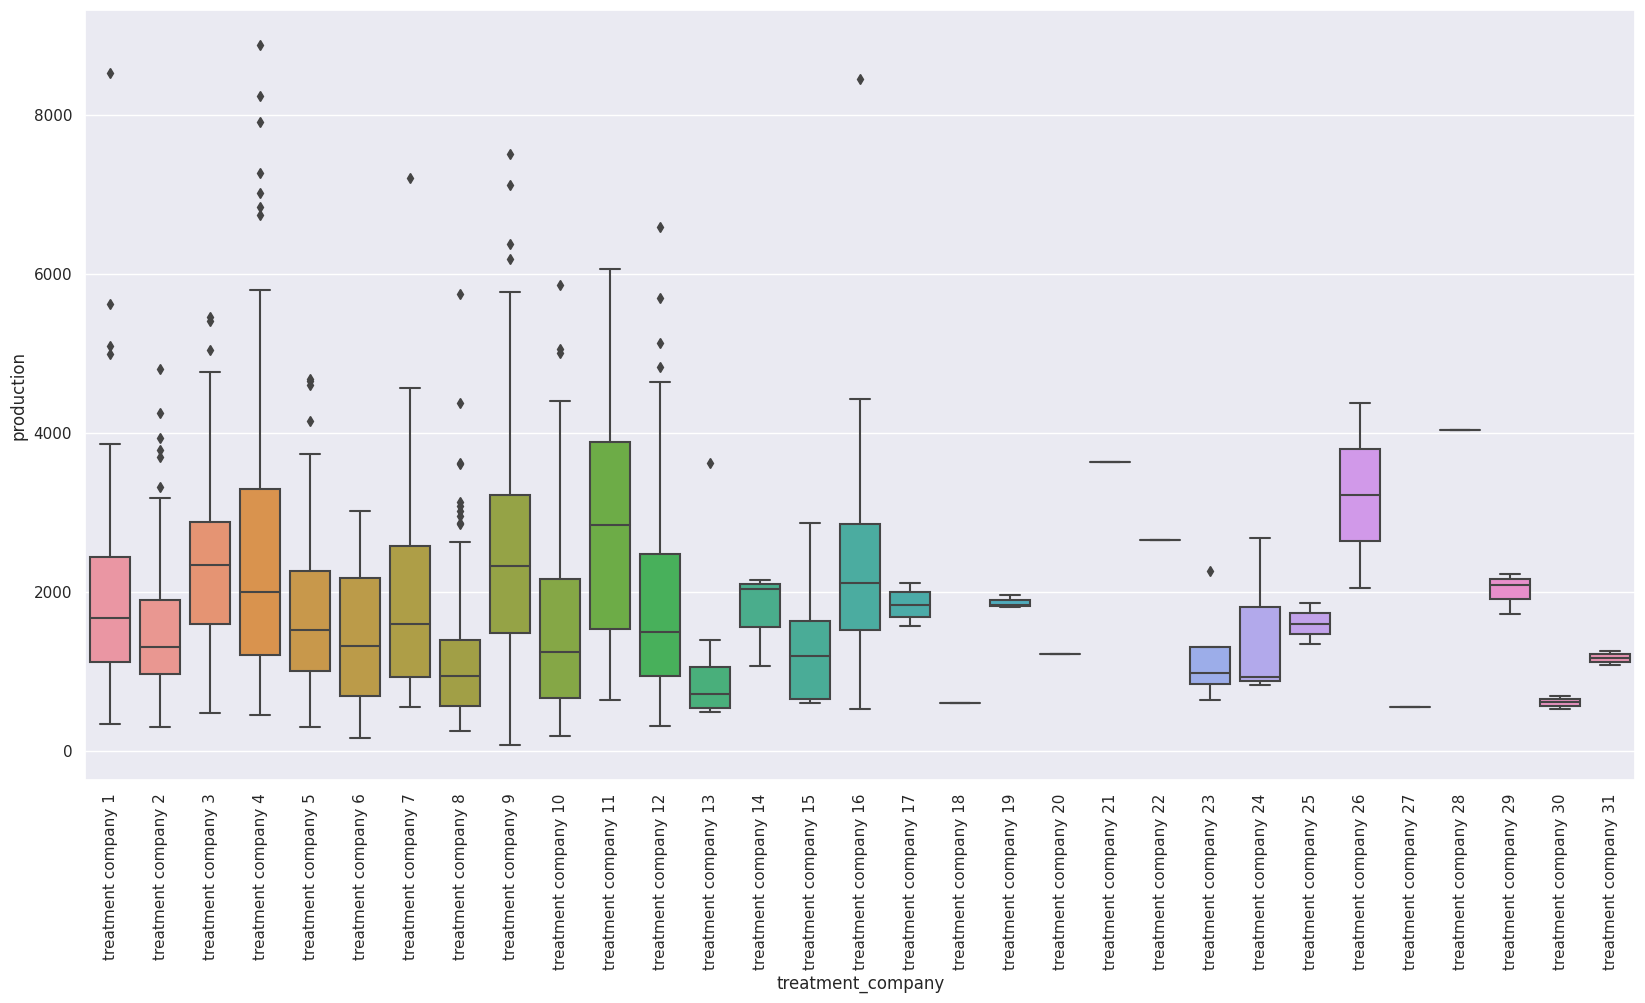

In [22]:
ax = sns.boxplot(x='treatment_company', y='production', data=df1);
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

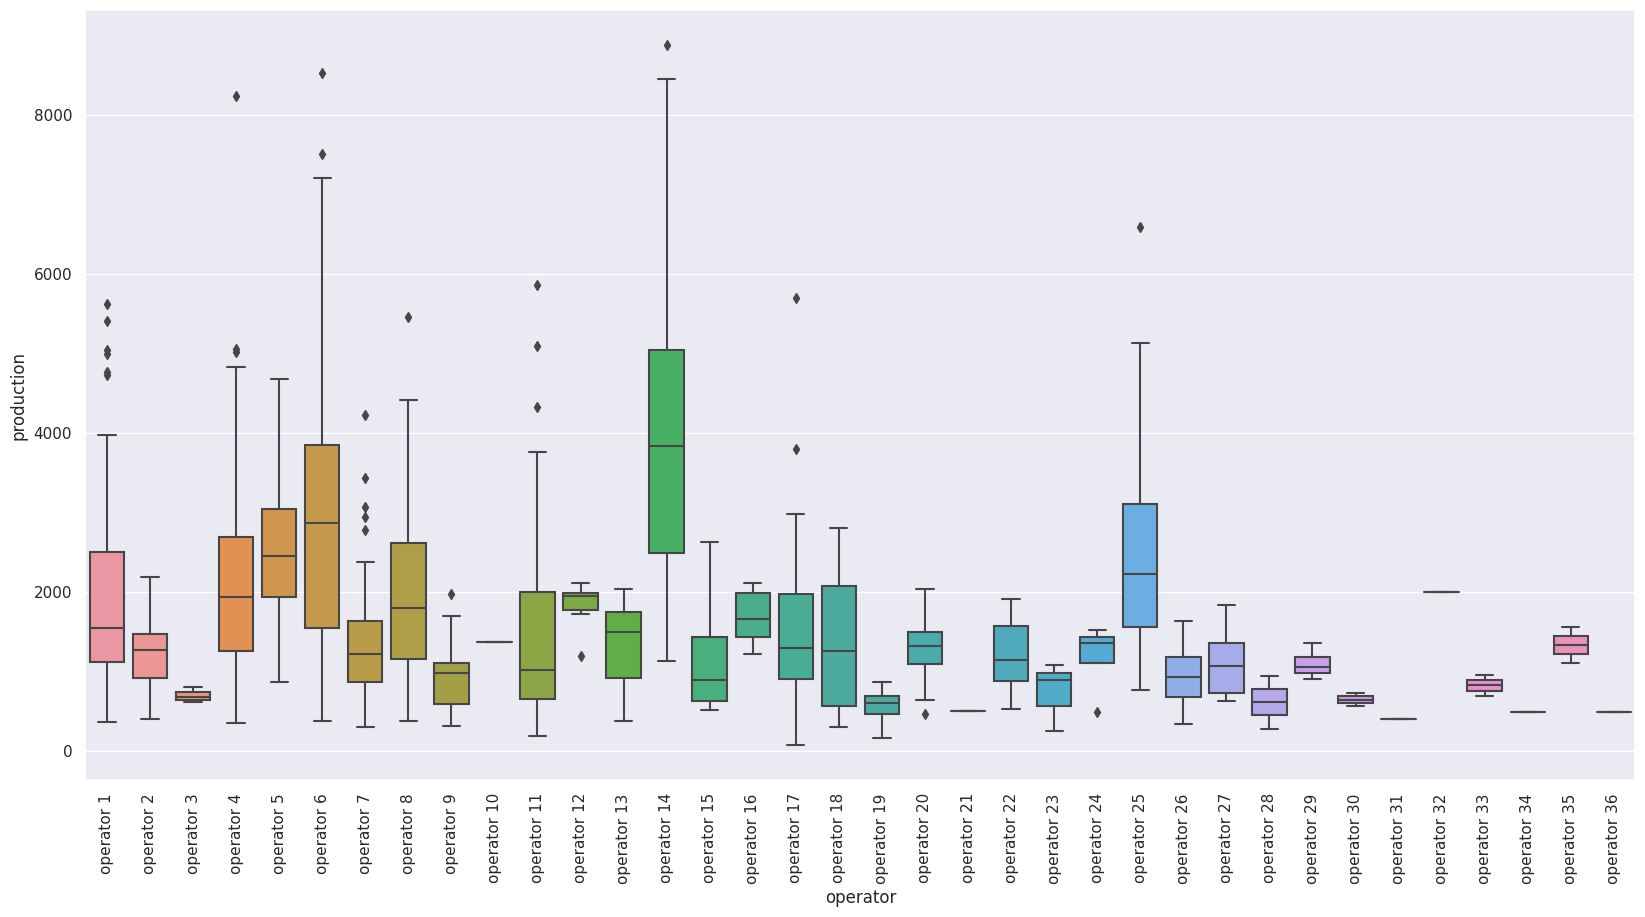

In [23]:
ax = sns.boxplot(x='operator', y='production', data=df1);
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

# 2. Feature Engineering

In [56]:
df2 = df1.copy()

In [57]:
df2['month_on_production'] = df2['date_on_production'].dt.month
df2['year_on_production'] = df2['date_on_production'].dt.year

In [58]:
print('Months: {}'.format(np.sort(df2['month_on_production'].unique())))
print('Years: {}'.format(np.sort(df2['year_on_production'].unique())))

Months: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Years: [2011 2012 2013 2014 2015 2016 2017 2018 2019]


# 3. EDA (Exploratory Data Analysis)

In [59]:
df3 = df2.copy()

## 3.1. Univariate Analysis

### 3.1.1. Response Variable

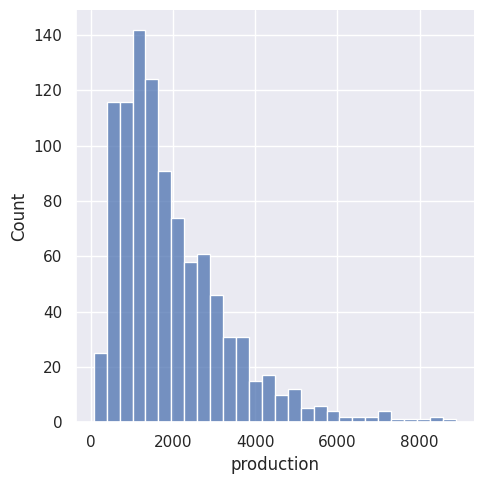

In [62]:
sns.displot(df1['production']);

### 3.1.1. Numerical Variables

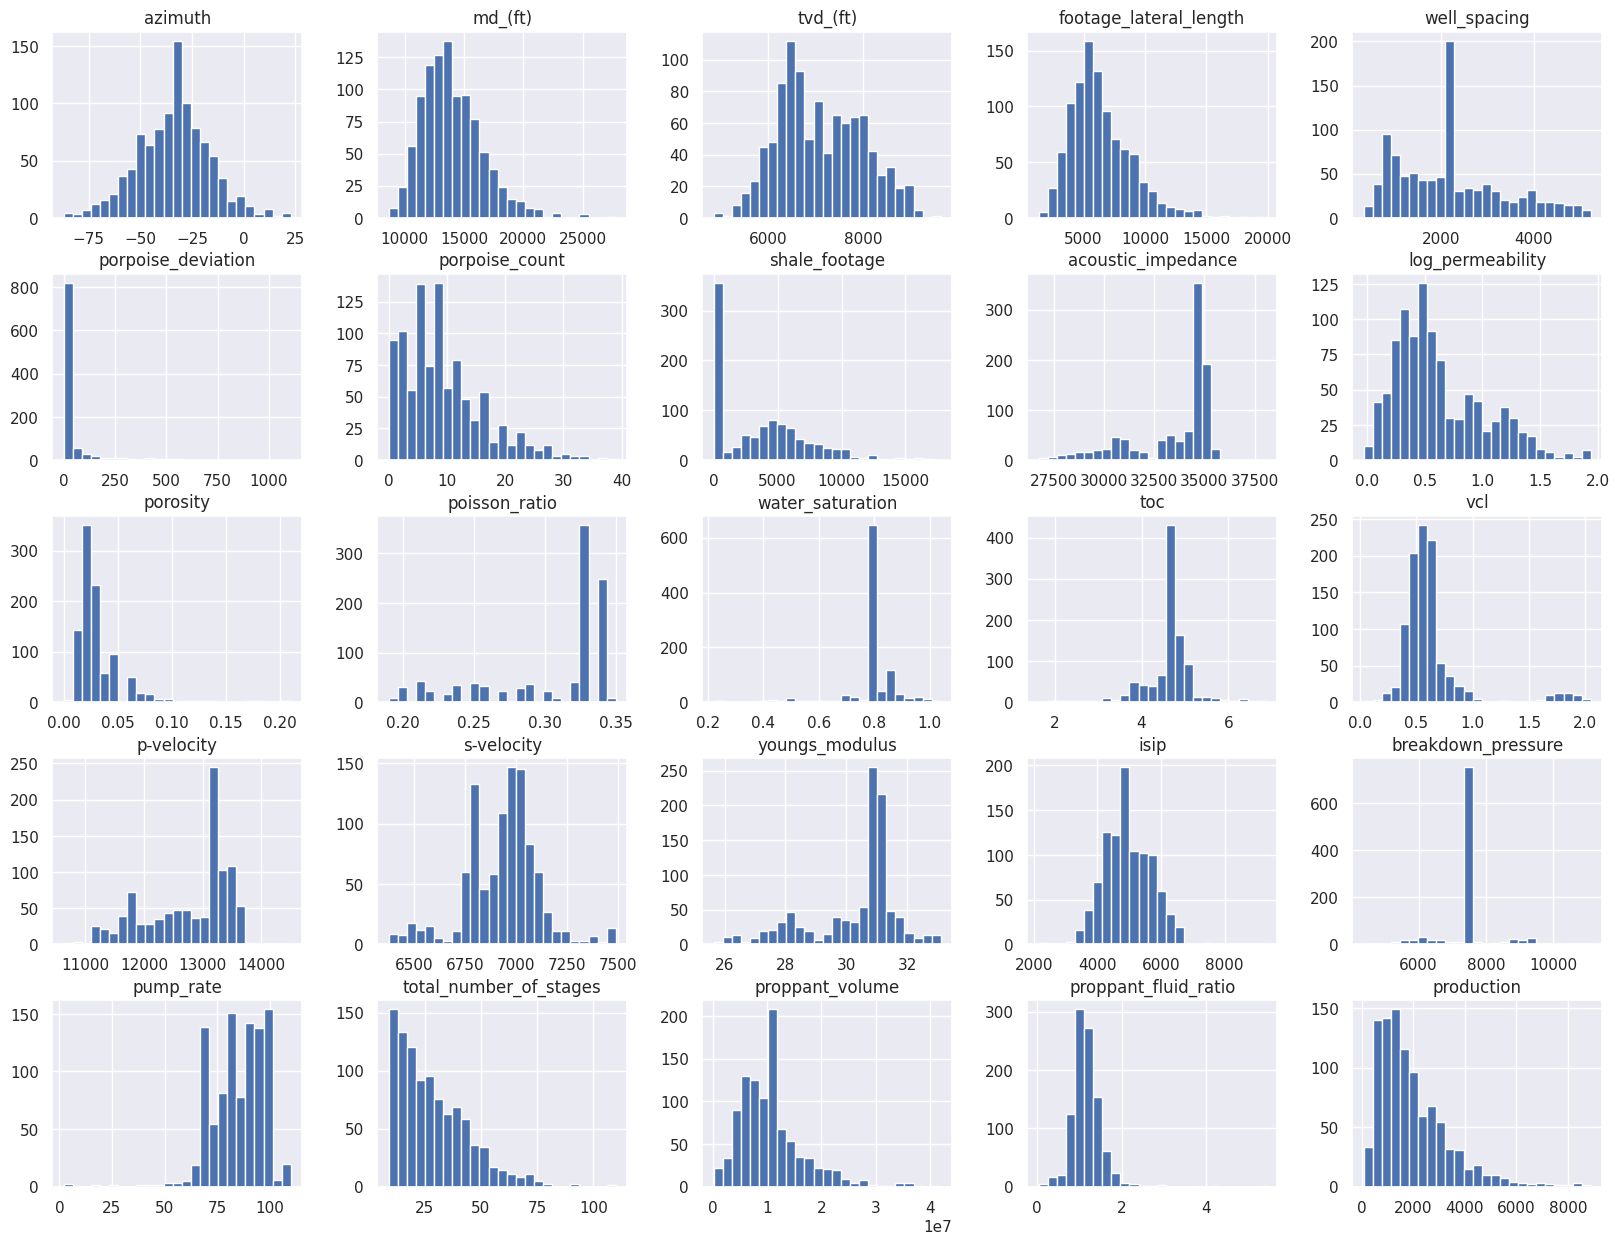

In [73]:
numerical_attributes.hist(bins=25, figsize=[20, 15]);


## 3.2. Multivariate Analysis

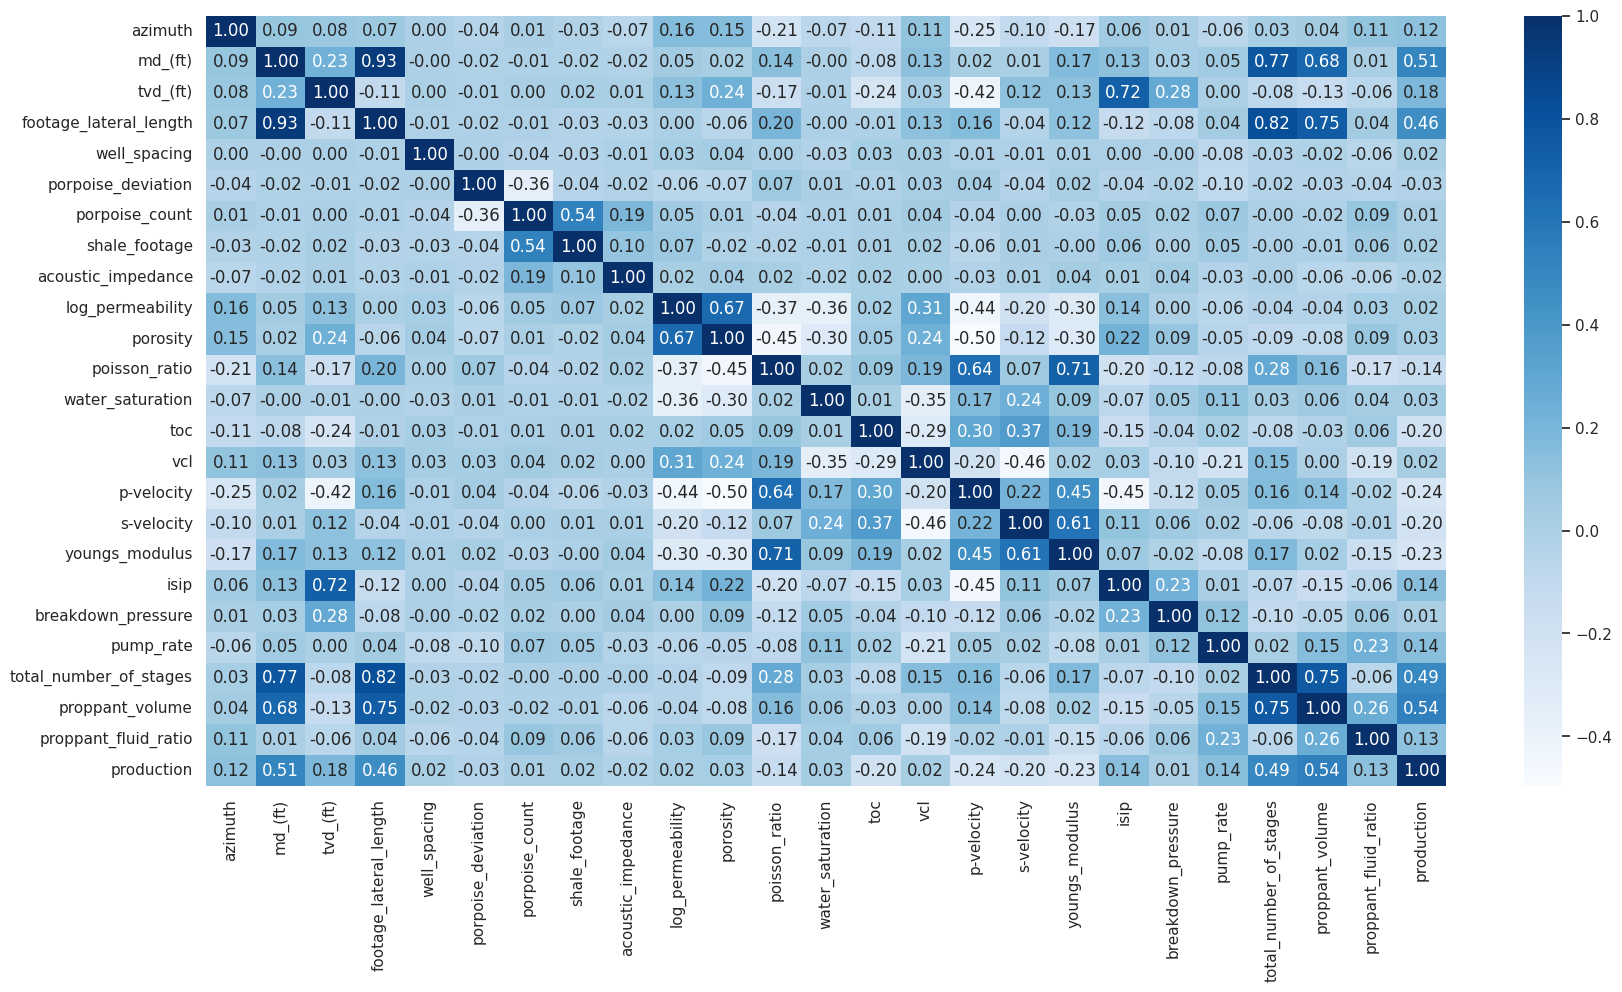

In [68]:
correlation = numerical_attributes.corr(method='pearson');
sns.heatmap(correlation, cmap="Blues", annot=True, fmt='.2f');